In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.decomposition import PCA
import offline_teachers as teach
import datasets as ds
import utils as ut
import data_output as op
import hypothesis as hp

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
num_teaching_itrs = 20
num_random_test_ims = 20
num_init_hyps = 100
density_sigma = 1.0
interp_sigma = 1.0
alpha = 0.5
image_scale = 2.0
hyp_type = 'k_cluster'  # rand, cluster, cluster_rand, sparse
# dataset_dir = dataset_root + dataset_name + '/'
url_root = ''  # set this to the location of the images on the web

save_ops = True
add_bias = True
remove_mean = True
do_pca = True
pca_dims = 2

experiment_id = hyp_type
op_dir = 'output/' + str(experiment_id) +'/'
if save_ops:
    print('saving output to', op_dir)
    if not os.path.isdir(op_dir):
        os.makedirs(op_dir)


def preprocess(X, remove_mean, do_pca, add_bias):

    # standardize
    if remove_mean:
        X = X - X.mean(0)
        X = X / X.std(0)

    # do PCA
    if do_pca and X.shape[1] > 2:
        pca = PCA(n_components=2, random_state=42)
        pca.fit(X)
        X = pca.transform(X)
        X = X - X.mean(0)
        X = X / X.std(0)

    # add 1 for bias (intercept) term
    if add_bias:
        X = np.hstack((X, np.ones(X.shape[0])[..., np.newaxis]))

    return X

def visualize_hyps(hyps):
    pca = PCA(n_components=2, random_state=42)
    hyps_2d = pca.fit_transform(np.vstack(hyps))
    plt.plot(hyps_2d)

saving output to output/k_cluster/


In [3]:
def pred_y(preds):
    # w_e = np.array([0.        , 0.3424866 , 0.        , 0.2356979 , 0.        ,
        # 0.        , 0.        , 0.42181548], dtype=np.float32)
    w_e = np.array([0.1101, 0.1751, 0.0000, 0.0000, 0.0000, 0.5072, 0.2076, 0.0000], dtype=np.float32)
    prob = preds @ w_e
    y_pred = prob
    y_pred[prob < 0.5] = 0
    y_pred[prob >= 0.5] = 1
    return y_pred.astype(np.int)

datasets = {}

saliency = pickle.load(open('../../data/prostatex/train.saliency.t.pkl', "rb"))

fids, inputs, labels, embeds, preds = pickle.load(open('../../data/prostatex/train_findings_emb10.pkl', "rb"))
dataset = {}
# X = embeds.reshape(inputs.shape[0], -1)
# dataset['X'] = preprocess(X, remove_mean, do_pca, add_bias)
dataset['X'] = embeds
dataset['Y'] = labels
dataset['im_files'] = inputs[:,0,:,:]
dataset['explain_files'] = np.asarray([''] * labels.shape[0])
dataset['class_names'] = np.asarray([''] * np.unique(labels).shape[0])
dataset['interp'] = saliency
dataset['explain_interp'] = ut.compute_interpretability(dataset['interp'], dataset['Y'], pred_y(preds), interp_sigma)
# dataset['explain_interp'] = np.ones(labels.shape[0])
datasets['train'] = dataset

fids, inputs, labels, embeds, preds = pickle.load(open('../../data/prostatex/valid_findings_emb10.pkl', "rb"))
dataset = {}
# X = embeds.reshape(inputs.shape[0], -1)
# dataset['X'] = preprocess(X, remove_mean, do_pca, add_bias)
dataset['X'] = embeds
dataset['Y'] = labels
dataset['im_files'] = inputs[:,0,:,:]
dataset['explain_files'] = np.asarray([''] * labels.shape[0])
dataset['class_names'] = np.asarray([''] * np.unique(labels).shape[0])
dataset['explain_interp'] = np.ones(labels.shape[0])
datasets['test'] = dataset

In [ ]:
# np.array(teachers['strict'].teaching_exs)
selected = [ 44, 197,  43, 146, 228,   1, 243,  60, 237,  61, 132, 219, 156,
       171, 164, 211, 152, 202,  65, 224]

In [8]:
err_hyp

array([0.62109375, 0.6953125 , 0.73046875, 0.4609375 , 0.59765625,
       0.61328125, 0.609375  , 0.703125  , 0.26953125, 0.68359375,
       0.59375   , 0.2421875 , 0.49609375, 0.45703125, 0.73828125,
       0.6484375 , 0.5234375 , 0.53125   , 0.62890625, 0.6015625 ,
       0.61328125, 0.62890625, 0.3984375 , 0.6953125 , 0.515625  ,
       0.3515625 , 0.2734375 , 0.65625   , 0.46484375, 0.45703125,
       0.52734375, 0.5       , 0.67578125, 0.5078125 , 0.53515625,
       0.4921875 , 0.6484375 , 0.40625   , 0.234375  , 0.5078125 ,
       0.51171875, 0.2890625 , 0.41796875, 0.3671875 , 0.52734375,
       0.59375   , 0.60546875, 0.66796875, 0.4375    , 0.484375  ,
       0.6015625 , 0.4375    , 0.51171875, 0.37109375, 0.40234375,
       0.49609375, 0.765625  , 0.27734375, 0.3984375 , 0.65234375,
       0.62890625, 0.55859375, 0.6171875 , 0.44921875, 0.4921875 ,
       0.4921875 , 0.62109375, 0.53125   , 0.34375   , 0.51171875,
       0.484375  , 0.56640625, 0.65625   , 0.48046875, 0.40234

In [4]:
import random
random.seed(42)
np.random.seed(42)

# load data
dataset_train, dataset_test = datasets['train'].copy(), datasets['test'].copy()
if len(np.unique(dataset_train['Y'])) > 2:
    one_v_all = True  # multi class
else:
    one_v_all = False # binary

 # density of points
dataset_train['X_density'] = ut.compute_density(dataset_train['X'], dataset_train['Y'], density_sigma, True)

# generate set of hypotheses
hyps, prior_h = hp.generate_hyps(dataset_train, alpha, num_init_hyps, hyp_type, one_v_all)
print(len(hyps), hyp_type, 'hypotheses\n')

# remove examples that are inconsistent with best hypothesis
if one_v_all:
    err_hyp = hp.compute_hyps_error_one_vs_all(hyps, dataset_train['X'], dataset_train['Y'], alpha)
else:
    err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
dataset_train = ds.remove_exs(dataset_train, hyps, err_hyp, alpha, 'train', one_v_all)

# re compute hypothesis errors - after removing inconsistent examples
if one_v_all:
    err_hyp = hp.compute_hyps_error_one_vs_all(hyps, dataset_train['X'], dataset_train['Y'], alpha)
    err_hyp_test = hp.compute_hyps_error_one_vs_all(hyps, dataset_test['X'], dataset_test['Y'], alpha)
else:
    err_hyp = hp.compute_hyps_error(hyps, dataset_train['X'], dataset_train['Y'], alpha)
    err_hyp_test = hp.compute_hyps_error(hyps, dataset_test['X'], dataset_test['Y'], alpha)

# compute the likelihood for each datapoint according to each hypothesis
if one_v_all:
    likelihood  = ut.compute_likelihood_one_vs_all(hyps, dataset_train['X'], dataset_train['Y'], alpha)
else:
    likelihood = ut.compute_likelihood(hyps, dataset_train['X'], dataset_train['Y'], alpha)

# teachers
teachers = {}
if one_v_all:
    teachers['rand_1vall'] = teach.RandomImageTeacherOneVsAll(dataset_train, alpha, prior_h)
    teachers['strict_1vall'] = teach.StrictTeacherOneVsAll(dataset_train, alpha, prior_h)
    # teachers['explain_1vall'] = teach.ExplainTeacherOneVsAll(dataset_train, alpha, prior_h)
else:
    teachers['random'] = teach.RandomImageTeacher(dataset_train, alpha, prior_h)
    teachers['strict'] = teach.StrictTeacher(dataset_train, alpha, prior_h)
    # teachers['explain'] = teach.ExplainTeacher(dataset_train, alpha, prior_h)

# run teaching
for alg_name in teachers.keys():
    print(alg_name)
    teachers[alg_name].run_teaching(num_teaching_itrs, dataset_train, likelihood, hyps, err_hyp, err_hyp_test)

870 possible combinations of PW classifers
101 k_cluster hypotheses

0 train examples removed
0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 2

In [10]:
teachers['strict'].difficulty

[0.7593267698887505,
 0.9660292909559638,
 0.8562528786812629,
 0.6546053331050263,
 0.9425834842111973,
 0.2842321227827731,
 0.18340443674599125,
 0.4224764364213321,
 0.4140941748119171,
 0.03451707164409768,
 0.6121953832364109,
 0.7852504919803547,
 0.1868981253676041,
 0.001261280616042178,
 0.010764075161714494,
 0.19150973995851867,
 0.8780748947060056,
 0.7127042559793394,
 0.8483422038469275,
 0.37880286206459507]


saving outputs


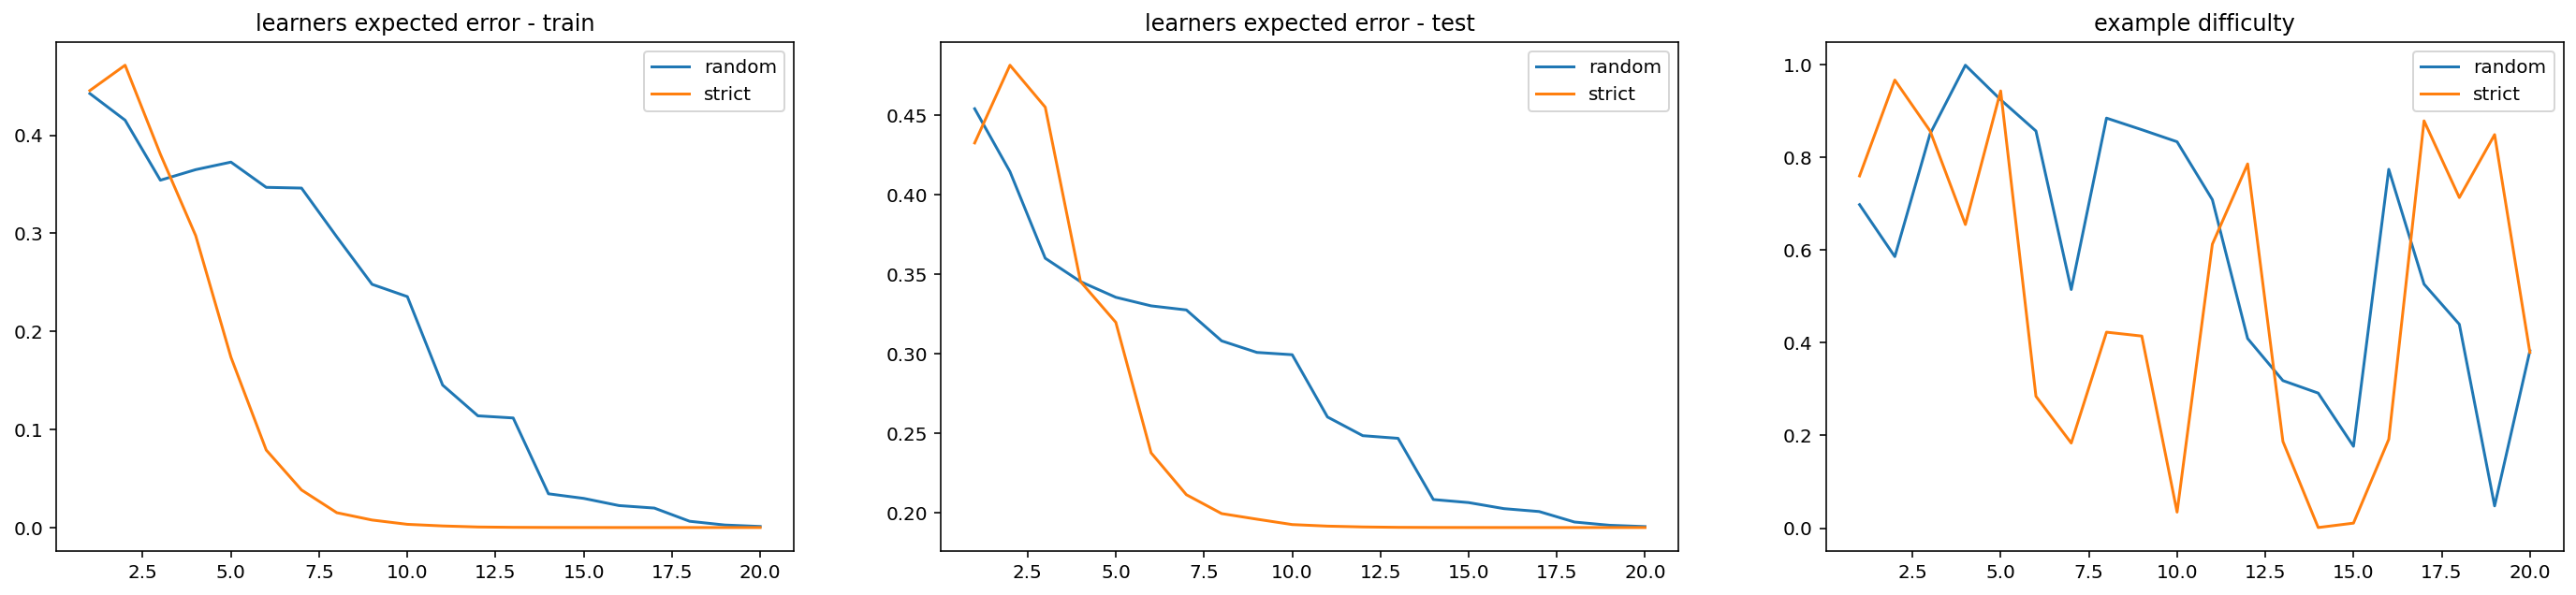

In [5]:
# plot in 2D
fig_id = 0
if (dataset_train['X'].shape[1] <= 3):
    for alg_name in teachers.keys():
        if one_v_all:
            ut.plot_2D_data(dataset_train['X'], dataset_train['Y'], alpha, hyps, teachers[alg_name].teaching_exs, teachers[alg_name].posterior(), alg_name, fig_id, one_v_all, np.argmin(err_hyp))
        else:
            ut.plot_2D_data_hyper(dataset_train['X'], dataset_train['Y'], alpha, hyps, teachers[alg_name].teaching_exs, teachers[alg_name].posterior(), alg_name, fig_id, one_v_all, np.argmin(err_hyp))
        fig_id += 1

fig, ax = plt.subplots(1, 3, figsize=(24, 5))

ax[0].set_title('learners expected error - train')
for alg_name in teachers.keys():
    exp_err = teachers[alg_name].exp_err
    ax[0].plot(np.arange(len(exp_err))+1, exp_err, label=alg_name)
ax[0].legend()
# if save_ops:
#     plt.savefig(op_dir + 'eer.pdf')

# plt.figure(fig_id+1, figsize=(4, 3))
ax[1].set_title('learners expected error - test')
for alg_name in teachers.keys():
    exp_err_test = teachers[alg_name].exp_err_test
    ax[1].plot(np.arange(len(exp_err_test))+1, exp_err_test, label=alg_name)
ax[1].legend()
# if save_ops:
#    plt.savefig(op_dir + 'eer_test.pdf')

# plt.figure(fig_id+2, figsize=(4, 3))
ax[2].set_title('example difficulty')
for alg_name in teachers.keys():
    difficulty = teachers[alg_name].difficulty
    ax[2].plot(np.arange(len(difficulty))+1, difficulty, label=alg_name)
ax[2].legend()
fig.show()

# save strategy files
if not save_ops:
    print('\nnot saving outputs')
else:
    print('\nsaving outputs')
    for alg_name in teachers.keys():
        op.save_teaching_sequence(teachers[alg_name], alg_name, op_dir + alg_name + '.strat')

    # op.save_teaching_images(dataset_train, dataset_test, op_dir + 'teaching_images.json', url_root)
    op.save_settings(dataset_train, dataset_test, experiment_id, num_random_test_ims, image_scale, op_dir + 'settings.json')
    np.savez(op_dir + 'params.npz', dataset_train=dataset_train, dataset_test=dataset_test, hyps=hyps, teachers=teachers)